In [31]:
import numpy as np
import matplotlib.pyplot as plt

class Convolution:
    #include init? idk
    # num_img_in: Number of inputs
    # filter_size: Size of kernel, will be square & less than 28
    # num_filters: Number of filters to run input against
    def __init__(self, num_img_in, filter_size, num_filters, step_size):
        self.num_img_in = num_img_in
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.step_size = step_size
        
    def forward_prop(self, img_in, features):
        N = len(img_in)
        M = len(img_in[0])
        step_size = self.step_size
        # if step size doesn't match up -> padding()
        # gives us amount of padding needed\n",
        pad_N = (N - len(features)) % step_size
        pad_M = (M - len(features[0])) % step_size
        img_in = self.padding(img_in, N+pad_N, M+pad_M) #padded img

        # should be whole numbers\n",
        P = (len(img_in) - len(features)) / step_size + 1
        Q = (len(img_in[0]) - len(features)) / step_size + 1

        # find good ways to add padding, possibly this part is not needed?
        if P.is_integer() is False:
            return "Bad Dimension P"
        if Q.is_integer() is False:
            return "Bad dimension Q"
        else:
            P = int(P)
            Q = int(Q)

        print(P, Q)
        out = np.zeros((self.num_filters, P, Q)) # PxQ output array\n",

        # iterate thru the input and output to corresponding part in out
        # output f amount of filters from each layer
        for f in range(0, self.num_filters):
            for i in range(0, P):
                for j in range (0, Q):
                    # Take dot product of the flattened filter and part it is covering\n",
                    out[f, i, j] = np.dot(np.ndarray.flatten(img_in[i:i+len(features),
                        j:j+len(features[0])]), np.ndarray.flatten(features))
        return out
        
    # Given set of filters (features) #odd x #odd, iterate over input and multiply
    # img_in: a square NxM #even x #even matrix representing one of the RGB values of the input
    # features: filters/features that we compare the input against
    # step_size: fixed to 1 (does not have any effect)
    # returns a NxM matrix where each value is the result of multiplying
    # filter with the input, then dividing by the size of the filter
    # pad
    # Need to add filters to feature map
    def forward_prop_A(self, img_in, features, pad):
        N = len(img_in)
        M = len(img_in[0])
        
        # padded img as specified
        img_in = self.padding(img_in, N + 2 * pad, M + 2 * pad)
        plt.imshow(features)
        plt.show()
        plt.imshow(img_in)
        plt.show()
        # print(img_in)

        # stride here is 1
        # out_N = (N - features_size + 2*pad_N) / stride + 1
        # out_M = (M - features_size + 2*pad_M) / stride + 1
        stride = 1
        # NxM output array (square)
        # assume the number is divisible by the stride
        out = np.zeros(((N - len(features) + 2 * pad) // stride + 1
                        , (M - len(features[0]) + 2 * pad) // stride + 1 ))
        
        # iterate thru the input and output to corresponding part in out
        #for f in range(0, self.num_filters):
        for i in range(0, len(out)):
            for j in range (0, len(out[0])):
                # Take dot product of the flattened filter and part of input it is covering
                out[i, j] = np.dot(np.ndarray.flatten(img_in[i:i+len(features),
                                j:j+len(features[0])]), np.ndarray.flatten(features))
        
        return out
    
    # assume stride = 1 (not tested for stride > 1)
    # loss = loss gradient from the next layer (feeding back to previous layer)
    # filter_weight = previous/original kernel/filter
    # learning_rate = alpha or how much change we want (the same across the network)
    # pad = pad_size must be the same as forward_prop's pad size for this layer.
    # loss_size = img_size
    def back_prop(self, img_in, loss, filter_weight, learning_rate, pad):
        dL_dF = np.zeros(np.shape(filter_weight))
        X = img_in
        N = len(X)
        M = len(X[0])

        # padded img
        X = self.padding(X, N + 2*pad, M + 2*pad)
        print("padded img", X)
        
        # update filter
        # X is the image @ this stage
        # chain rule: dL_dF = dL_dO * dO_dF
        # but dL_dO is the input loss
        # and dO_dF results in the image X
        # dL_dF = convolution 2d between X (image @ this stage) and loss   
        # ex. dL_dF 3x3 =  Conv image 4x4 (padded to 6x6), loss 4x4
        for i in range(0, N - 1):
            for j in range (0, M - 1):
                # print(np.ndarray.flatten(X[i:i+len(loss), j:j+len(loss[0])]))
                dL_dF[i, j] = np.dot(np.ndarray.flatten(X[i:i+len(loss),
                            j:j+len(loss[0])]), np.ndarray.flatten(loss))
        print("dL_dF")
        print(dL_dF)
        
        
        # update the image X
        # need to rotate the filter 180deg and pad it
        # convolution from right to left and bottom to top
        # F33 F32 F31
        # F23 F22 F21
        # F13 F12 F11
        dL_dX = np.zeros(np.shape(img_in))
        # rotate the filter 180deg
        rot_filter_weight = np.rot90(filter_weight, 2)
        # pad the filter 
        loss = self.padding(loss, N + 2*pad, M + 2*pad)
        print("padded loss")
        print(loss)
        # dL_dX = convolution 2d between rot180(Filter) and loss 
        # convolution from right to left and bottom to top
        for i in range(N - 1, -1, -1):
            for j in range (M - 1, -1, -1):
                #print(i,j)
                #print(np.ndarray.flatten(loss[i:i+len(rot_filter_weight), j:j+len(rot_filter_weight[0])]))
                dL_dX[i, j] = np.dot(np.ndarray.flatten(loss[i:i+len(rot_filter_weight),
                            j:j+len(rot_filter_weight[0])]), np.ndarray.flatten(rot_filter_weight))
        
        print("dL_dX")
        print(dL_dX)
        # F = F - a * dL/dF
        filter_weight = filter_weight - learning_rate * dL_dF
        print("updated_features")
        print(filter_weight)
        return filter_weight, X
    
    # Add 0s to the border of orig_img as needed to achieve NxM matrix
    # assume orig_img is a square matrix with #odd x #odd
    def padding(self, orig_img, N, M):
        if N - orig_img.shape[0] < 0 or M - orig_img.shape[1] < 0:
            raise "target NxM must be larger or equal to orig_img"
        starting_row = (N - orig_img.shape[0]) // 2
        starting_column = (M - orig_img.shape[1]) // 2
        pad_arr = np.zeros((N, M))
        pad_arr[starting_row:starting_row+orig_img.shape[0], starting_column:starting_column+orig_img.shape[1]] = orig_img
        return pad_arr
    
# Can implement either max or avg pooling, going w max for now
class Pooling:
    
    def __init__(self, pool_dim):
        # input data to pooling
        #self.img_in = img_in
        # need to remember which indices provide the local max for back_prop
        # self.mask = np.zeros((len(img_in),len(img_in[0])))
        # pooling dimension for this layer
        self.pool_dim = pool_dim
        # output data from pooling
        # reduce by a factor of whatever stride is
        #self.out = np.zeros((len(img_in) // self.pool_dim, len(img_in[0]) // self.pool_dim))
    
    # Go thru sections of the original matrix and only take the highest value
    # Put this into a new PxQ matrix
    # Pool dim is a single int representing both size of the 'pool filter' and
    # the stride. Ex: 2 -> 2x2 pooling with stride 2
    def forward_prop(self, img_in):
        # Input known at runtime, not while adding layers
        self.img_in = img_in
        self.out = np.zeros((len(img_in) // self.pool_dim, len(img_in[0]) // self.pool_dim))
        self.mask = np.zeros((len(img_in),len(img_in[0])))
        
        pool_dim = self.pool_dim
        # loop thru input matrix
        for i in range(0, len(self.out)):
            for j in range(0, len(self.out[0])):
                # get largest value in pool
                vert = i * pool_dim
                horiz = j * pool_dim
                pool = self.img_in[vert:vert+pool_dim, horiz:horiz+pool_dim]
                #print(pool)
                self.out[i,j] = np.amax(pool)
                max_idx = np.argmax(pool)
                # flag local max indices
                self.mask[vert + max_idx // pool_dim, horiz + max_idx % pool_dim] = 1.0
              
        return self.out, self.mask
    
    # only send loss to those local max's, the rest is 0
    def back_prop(self, loss):
        # cheap fix to get the 1d index
        loss_flattened = np.ndarray.flatten(loss)
        count = 0
        back_loss = np.zeros((len(self.mask),len(self.mask[0])))
        
        for i in range(0, len(self.mask)):
            for j in range(0, len(self.mask[0])):
                if self.mask[i,j] == 1:
                    back_loss[i,j] = loss_flattened[count]
                    count = count + 1
                else:
                    back_loss[i,j] = 0
        # zero out mask for the next iteration
        # self.mask = np.zeros((len(img_in),len(img_in[0])))
        return back_loss
    
    def padding(self, orig_img, N, M):
        starting_row = int((N - orig_img.shape[0]) // 2)
        starting_column = int((M - orig_img.shape[1]) // 2)
        pad_arr = np.zeros((N, M))
        pad_arr[starting_row:starting_row+orig_img.shape[0], starting_column:starting_column+orig_img.shape[1]] = orig_img
        return pad_arr
    
class ReLU():
    
    def __init__(self):
        #self.img_in = img_in
        pass
        
    def forward_prop(self, img_in):
        self.img_in = img_in
        for i in range(0, len(self.img_in)):
            for j in range(0, len(self.img_in[0])):
                if self.img_in[i, j] < 0:
                    self.img_in[i, j] = 0.0
        return self.img_in
    
    # send loss to those location with input > 0, the rest is 0
    def back_prop(self, loss):
        back_loss = np.zeros(np.shape(self.img_in))
        for i in range(0, len(self.img_in)):
            for j in range(0, len(self.img_in[0])):
                # print(self.img_in[i, j])
                if self.img_in[i, j] <= 0:
                    back_loss[i,j] = 0
                else:
                    back_loss[i,j] = loss[i,j]
        print("back_loss")
        print(back_loss)
        return back_loss
    
    
## COPIED ##
class FullyConnected:

    def __init__(self, num_inputs, num_outputs, learning_rate):
        self.weights = 0.01*np.random.rand(num_inputs, num_outputs)
        self.bias = np.zeros((num_outputs, 1))
        self.lr = learning_rate

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(self.inputs, self.weights) + self.bias.T

    def backward(self, dy):

        if dy.shape[0] == self.inputs.shape[0]:
            dy = dy.T
        dw = dy.dot(self.inputs)
        db = np.sum(dy, axis=1, keepdims=True)
        dx = np.dot(dy.T, self.weights.T)

        self.weights -= self.lr * dw.T
        self.bias -= self.lr * db

        return dx

    def extract(self):
        return {self.name+'.weights':self.weights, self.name+'.bias':self.bias}

    def feed(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
        
## COPIED ##
class Softmax:
    def __init__(self):
        pass
    def forward(self, inputs):
        exp = np.exp(inputs, dtype=np.float)
        self.out = exp/np.sum(exp)
        return self.out
    def backward(self, dy):
        return self.out.T - dy.reshape(dy.shape[0],1)
    def extract(self):
        return
    
class Sigmoid_Act():
    def forward_prop():
        return None
    def back_prop():
        return None
          

TEST: conv_forward


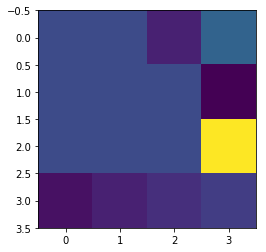

2 2
TEST: pool_forward
(array([[ 6.,  8.],
       [ 5.,  4.]]), array([[ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.]]))
(array([[ 6.,  8.],
       [ 5.,  4.]]), array([[ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.]]))
TEST: ReLU
[[5 0 0]
 [0 6 2]
 [5 0 0]]


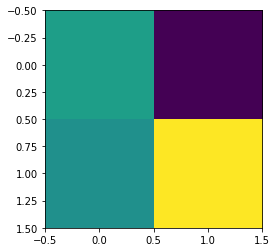

In [24]:
# # tests
# def test_conv_forward():
#     test_arr = np.array(([5, 5, 2, 7],
#                          [5, 5, 5, 0],
#                          [5, 5, 5, 22],
#                          [1, 2, 3, 4]))
#     feat_arr = np.array(([2, -1, 0], 
#                          [2, 1, 1],
#                          [1, 0, -1]))
#     plt.imshow(test_arr)
#     plt.show()
#     conv_layer = Convolution(1, 3, 1)
#     plt.imshow(conv_layer.forward_prop(test_arr, feat_arr,1))
    
# def test_pool_forward():
#     test_arr = np.array(([5, 5, 2, 8],
#                          [5, 6, 2, 1],
#                          [5, 5, 4, -4],
#                          [1, 4, 2, 3]))
#     pool_dim = 2
#     pool_layer = Pooling(pool_dim)
#     print(pool_layer.forward_prop(test_arr))
#     pool_layer = Pooling(pool_dim)
#     pool_dim = 1
#     print(pool_layer.forward_prop(test_arr))
    
# def test_ReLU():
#     test_arr = np.array(([5, -1, -1],
#                          [-4, 6, 2],
#                          [5, 0, -3333]))
#     ReLU_layer = ReLU()
#     print(ReLU_layer.forward_prop(test_arr))
    
# print("TEST: conv_forward")    
# test_conv_forward()
# print("TEST: pool_forward")
# test_pool_forward()
# print("TEST: ReLU")
# test_ReLU()

In [26]:
# # tests 2
# # def padding(self, orig_img, N, M)
# def test_padding():
#     conv_layer = Convolution(1, 6, 6)
#     test_arr = np.array(([5, 5, 2, 7],
#                          [5, 5, 5, 0],
#                          [5, 5, 5, 22],
#                          [1, 2, 3, 4]))
#     print(conv_layer.padding(test_arr,6,6))
#     test_arr = np.array(([5, 5, 2, 7],
#                          [5, 5, 5, 0],
#                          [5, 5, 5, 22],
#                          [1, 2, 3, 4]))
#     print(conv_layer.padding(test_arr,8,8))
#     test_arr = np.array(([2, 3],
#                          [4, 5]))
#     print(conv_layer.padding(test_arr,4,4))
    
#     test_arr = np.array(([2, 3],
#                          [4, 5]))
#     print(conv_layer.padding(test_arr,2,2))
    
# print("TEST: padding")
# test_padding()

TEST: padding
[[  0.   0.   0.   0.   0.   0.]
 [  0.   5.   5.   2.   7.   0.]
 [  0.   5.   5.   5.   0.   0.]
 [  0.   5.   5.   5.  22.   0.]
 [  0.   1.   2.   3.   4.   0.]
 [  0.   0.   0.   0.   0.   0.]]
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   5.   5.   2.   7.   0.   0.]
 [  0.   0.   5.   5.   5.   0.   0.   0.]
 [  0.   0.   5.   5.   5.  22.   0.   0.]
 [  0.   0.   1.   2.   3.   4.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 0.  2.  3.  0.]
 [ 0.  4.  5.  0.]
 [ 0.  0.  0.  0.]]
[[ 2.  3.]
 [ 4.  5.]]


In [27]:
# # tests 3
# # def back_prop(self, img_in, loss, features, learning_rate)
# def test_conv_backward():
#     test_arr = np.array(([5, 5, 2, 7],
#                          [5, 5, 5, 0],
#                          [5, 5, 5, 22],
#                          [4, 3, 2, 1]))
#     feat_arr = np.array(([2, -1, 0], 
#                          [2, 1, 1],
#                          [1, 0, -1]))
#     loss = np.array(([5, 3, 1, 9], 
#                      [2, 4, 6, -1],
#                      [9, 7, 5, -3],
#                      [-1,-2,-3,-4]))
#     conv_layer = Convolution(1, 3, 1)
#     conv_layer.back_prop(test_arr, loss, feat_arr, 0.01, 1)
    
# print("TEST: conv_back_prop")
# test_conv_backward()

TEST: conv_back_prop
padded img [[  0.   0.   0.   0.   0.   0.]
 [  0.   5.   5.   2.   7.   0.]
 [  0.   5.   5.   5.   0.   0.]
 [  0.   5.   5.   5.  22.   0.]
 [  0.   4.   3.   2.   1.   0.]
 [  0.   0.   0.   0.   0.   0.]]
dL_dF
[[  48.   22.   59.]
 [ 103.  184.  248.]
 [ 147.  147.  248.]]
padded loss
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  5.  3.  1.  9.  0.]
 [ 0.  2.  4.  6. -1.  0.]
 [ 0.  9.  7.  5. -3.  0.]
 [ 0. -1. -2. -3. -4.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
dL_dX
[[ 17.  18.  14.  11.]
 [ 18.  17.   3.   7.]
 [ 24.  26.  -4.   0.]
 [  2. -13. -23. -12.]]
updated_features
[[ 1.52 -1.22 -0.59]
 [ 0.97 -0.84 -1.48]
 [-0.47 -1.47 -3.48]]


In [28]:
# # def back_prop(self, loss):
# def test_pooling_backward():
#     test_arr = np.array(([5, 5, 2, 8],
#                              [5, 6, 2, 1],
#                              [5, 5, 4, -4],
#                              [1, 4, 2, 3]))
#     test_loss = np.array(([9,4],[1,-8]))
#     pool_dim = 2
#     pool_layer = Pooling(pool_dim)
#     print(pool_layer.forward_prop(test_arr))
#     print(pool_layer.back_prop(test_loss))
    
# print("TEST: pool_back_prop")
# test_pooling_backward()

TEST: pool_back_prop
(array([[ 6.,  8.],
       [ 5.,  4.]]), array([[ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.]]))
[[ 0.  0.  0.  9.]
 [ 0.  4.  0.  0.]
 [ 1.  0. -8.  0.]
 [ 0.  0.  0.  0.]]


In [29]:
# # def back_prop(self, loss):
# def test_ReLU_backward():
#     test_arr = np.array(([5, -1, -1],
#                          [-4, 6, 2],
#                          [5, 0, -3333]))
#     ReLU_layer = ReLU()
#     ReLU_layer.forward_prop(test_arr)
#     test_loss = np.array(([1, 2, 3],
#                          [4, 5, 6],
#                          [7, 8, 9]))
#     ReLU_layer.back_prop(test_loss)

# print("TEST: relu_back_prop")
# test_ReLU_backward()

TEST: relu_back_prop
back_loss
[[ 1.  0.  0.]
 [ 0.  5.  6.]
 [ 7.  0.  0.]]
